In [1]:
import torch
from purias_utils.util.arguments_yaml import ConfigNamepace
from ddpm import tasks, model
import matplotlib.pyplot as plt

device = 'cuda'

In [2]:
def generate_model_and_task_from_args_path(args_path, device):

    args = ConfigNamepace.from_yaml_path(args_path)
    
    task: tasks.WMDiffusionTask = getattr(tasks, args.task_name)(**args.task_config.dict)

    sigma2x_schedule = torch.linspace(args.starting_sigma2, args.ultimate_sigma2, args.num_timesteps)
    sigma2x_schedule = sigma2x_schedule.to(device=device)

    model_config = args.model_config

    residual_model_kwargs = model_config.dict.pop('residual_model_kwargs').dict
    ddpm_model_kwargs = model_config.dict.pop('ddpm_model_kwargs').dict
    ddpm_model, mse_key = getattr(model, args.model_name)(
        **model_config.dict, residual_model_kwargs=residual_model_kwargs, ddpm_model_kwargs=ddpm_model_kwargs,
        sigma2x_schedule = sigma2x_schedule, sensory_shape = task.sensory_gen.sensory_shape, sample_shape = task.sample_gen.sample_shape,
        device = device
    )

    ddpm_model.to(device)

    return args, task, ddpm_model, mse_key

def replace_nullspace_activity_partway_through_generation(diffusion_model, network_input, post_prep_state, replacement_activity, replacement_t_idx):
    """
    replacement_activity can be rich in the behaviour space too - nullspace activity will be extracted here!
    """
    assert isinstance(diffusion_model, model.PreparatoryLinearSubspaceTeacherForcedDDPMReverseProcess)

    network_input_mult = 1.0 if diffusion_model.network_input_during_diffusion else 0.0

    midway_samples_dict = super(type(diffusion_model), diffusion_model).generate_samples(
        network_input = network_input * network_input_mult,
        samples_shape = None,
        base_samples = post_prep_state,
        noise_scaler = 1.0,
        kwargs_for_residual_model = {},
        start_t_idx = 1,
        end_t_idx = replacement_t_idx
    )

    if replacement_activity is not None:
        assert post_prep_state.shape == replacement_activity.shape
        replacement_activity_nullspace = replacement_activity @ diffusion_model.behaviour_nullspace_accessor
    else:
        replacement_activity_nullspace = midway_samples_dict['end_state'].flip(0)    

    midway_state = midway_samples_dict['end_state']
    midway_state = midway_state - (midway_state @ diffusion_model.behaviour_nullspace_accessor)
    midway_state = midway_state + replacement_activity_nullspace

    end_samples_dict = super(type(diffusion_model), diffusion_model).generate_samples(
        network_input = network_input * network_input_mult,
        samples_shape = None,
        base_samples = midway_state,
        noise_scaler = 1.0,
        kwargs_for_residual_model = {},
        start_t_idx = replacement_t_idx + 1,
        end_t_idx = None
    )

    return midway_samples_dict, end_samples_dict

### Network trained with stimulus during diffusion does not depend on preparatory period to sample - entirely relies on stimulus during the denoising phase

In [3]:
# _, task, ddpm_model, _ = generate_model_and_task_from_args_path('/homes/pr450/repos/research_projects/error_modelling_torus/results_link_sampler/ddpm_recoup_20250108/run_e_teacher_forced_more_d_bimodal_0/args.yaml', device)
# ddpm_model.load_state_dict(torch.load('/homes/pr450/repos/research_projects/error_modelling_torus/results_link_sampler/ddpm_recoup_20250108/run_e_teacher_forced_more_d_bimodal_0/state_T100.mdl'))

### Network trained without stimulus does!

In [4]:
device = 'cuda'
_, task, ddpm_model, _ = generate_model_and_task_from_args_path('/homes/pr450/repos/research_projects/error_modelling_torus/results_link_sampler/ddpm_recoup_20250108/run_f_teacher_forced_more_d_bimodal_memory_2/args.yaml', device)
ddpm_model.load_state_dict(torch.load('/homes/pr450/repos/research_projects/error_modelling_torus/results_link_sampler/ddpm_recoup_20250108/run_f_teacher_forced_more_d_bimodal_memory_2/state.mdl'))

<All keys matched successfully>

Text(0.5, 1.0, '')

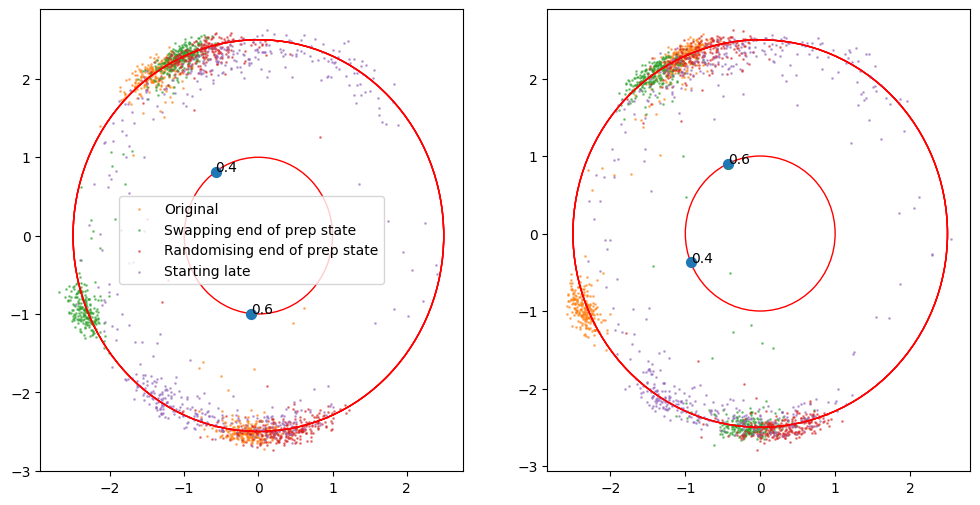

In [5]:
num_samples = 512

trial_information = task.generate_trial_information(batch_size=2, num_samples=1)
network_inputs = trial_information.network_inputs.repeat(1, num_samples, 1)



novel_samples_dict = ddpm_model.generate_samples(
    network_input = network_inputs,
    samples_shape = [2, num_samples],
)

network_input_mult = 1.0 if ddpm_model.network_input_during_diffusion else 0.0

swapped_novel_samples_dict = super(type(ddpm_model), ddpm_model).generate_samples(
    network_input = network_input_mult * network_inputs,             # Right way around
    base_samples = novel_samples_dict['postprep_state'].flip(0)                             # Wrong way around
)
rand_init_novel_samples_dict = super(type(ddpm_model), ddpm_model).generate_samples(
    network_input = network_input_mult * network_inputs,
    base_samples = torch.randn_like(novel_samples_dict['postprep_state'])
)
late_start_novel_samples_dict = ddpm_model.generate_samples(
    network_input = network_input_mult * network_inputs,
    samples_shape = [2, num_samples],
    start_t_idx = 30
)

fig,axes = plt.subplots(1, 2, figsize = (12, 6))
for i in range(2):
    task.task_variable_gen.display_task_variables(trial_information.task_variable_information, axes[i], batch_idx=i)
    task.sample_gen.display_samples(novel_samples_dict['samples'][[i]], axes[i], label = 'Original')
    task.sample_gen.display_samples(swapped_novel_samples_dict['samples'][[i]], axes[i], label = 'Swapping end of prep state')
    task.sample_gen.display_samples(rand_init_novel_samples_dict['samples'][[i]], axes[i], label = 'Randomising end of prep state')
    task.sample_gen.display_samples(late_start_novel_samples_dict['samples'][[i]], axes[i], label = 'Starting late')

axes[0].legend()

axes[0].set_title('')
axes[1].set_title('')

If we replace the nullspace activity in the first steps of denoising...

the memory network (only) swaps the distribution of samples it takes
It (alone) is using the nullspace to drive score estimation throughout the diffusion time

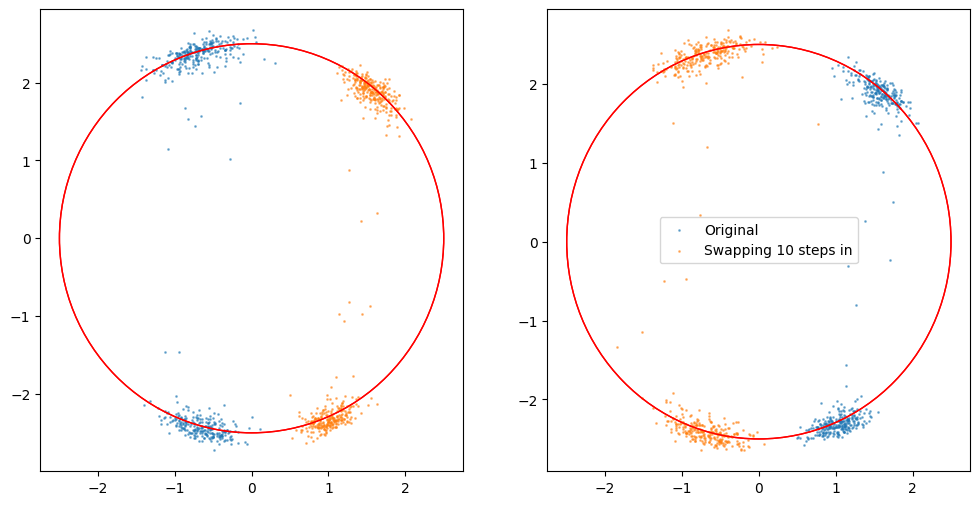

In [14]:
num_samples = 512

trial_information = task.generate_trial_information(batch_size=2, num_samples=1)

novel_samples_dict = ddpm_model.generate_samples(
    network_input = trial_information.network_inputs.repeat(1, num_samples, 1),
    samples_shape = [2, num_samples],
)

midway_samples_dict, end_samples_dict = replace_nullspace_activity_partway_through_generation(
    diffusion_model = ddpm_model,
    network_input = trial_information.network_inputs.repeat(1, num_samples, 1),
    post_prep_state = novel_samples_dict['postprep_state'],
    replacement_activity = None, 
    replacement_t_idx = 10
)

fig,axes = plt.subplots(1, 2, figsize = (12, 6))
for i in range(2):
    task.sample_gen.display_samples(novel_samples_dict['samples'][[i]], axes[i], label = 'Original')
    task.sample_gen.display_samples(end_samples_dict['samples'][[i]], axes[i], label = 'Swapping 10 steps in')
axes[i].legend()

...and we can do the same in the *last* 10 steps of denoising, ang get the same results

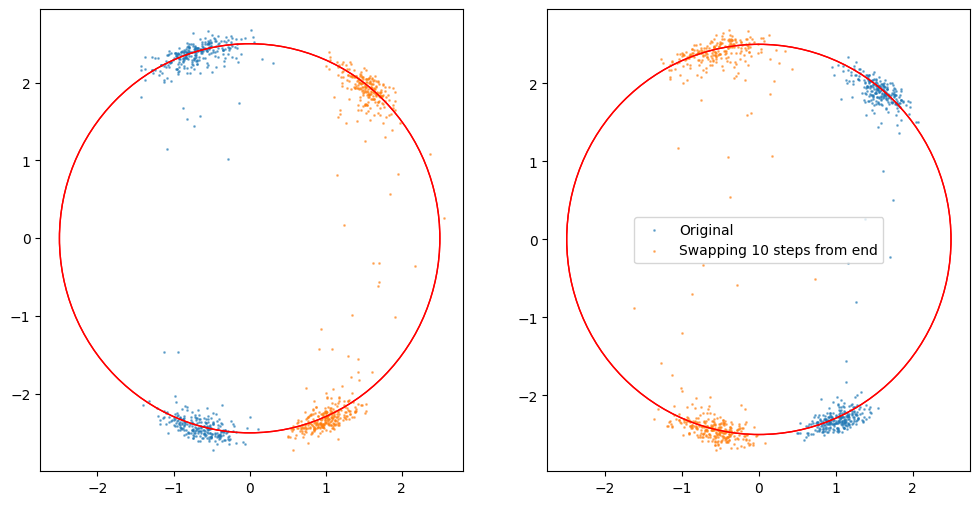

In [15]:
later_replacement_idx = 90

midway_samples_dict, end_samples_dict = replace_nullspace_activity_partway_through_generation(
    diffusion_model = ddpm_model,
    network_input = trial_information.network_inputs.repeat(1, num_samples, 1),
    post_prep_state = novel_samples_dict['postprep_state'],
    replacement_activity = None, 
    replacement_t_idx = later_replacement_idx
)

fig,axes = plt.subplots(1, 2, figsize = (12, 6))
for i in range(2):
    task.sample_gen.display_samples(novel_samples_dict['samples'][[i]], axes[i], label = 'Original')
    task.sample_gen.display_samples(end_samples_dict['samples'][[i]], axes[i], label = 'Swapping 10 steps from end')
axes[i].legend()

# From here on out, we focus the network which isn't given a stimulus during denoising

Clearly, both the end of prep activity *and* the ongoing denoising time activity in the nullspace are important to behaviour sampling.

First, we must find a way to classify which trajectories end up in which mode

This is easy, which just do a linear classifier on the point on the unit circle

We are just using the trajectories from the uninterrupted sampling process below...

(-4.0, 4.0)

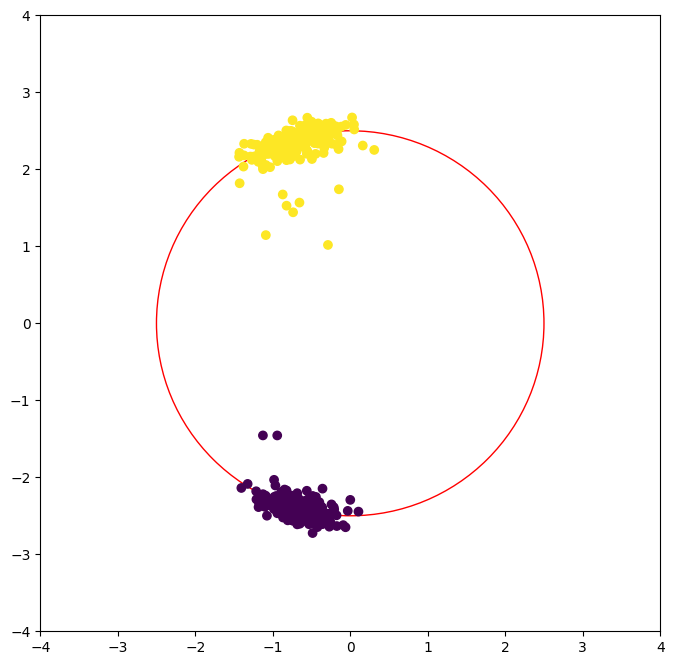

In [16]:
batch_idx = 0

mode_centers = trial_information.task_variable_information['report_features_cart'][batch_idx]

final_samples = novel_samples_dict['samples'][batch_idx]

distances_to_mode_centers = (final_samples.unsqueeze(1) - mode_centers.unsqueeze(0)).square().sum(-1).sqrt()
mode_1_mask = distances_to_mode_centers[:,0] < distances_to_mode_centers[:,1]

fig, axes = plt.subplots(1, figsize = (8,8))
axes.add_patch(plt.Circle((0, 0), 2.5, color='red', fill = False))
axes.scatter(*final_samples.T, c = mode_1_mask)
axes.set_xlim(-4,4); axes.set_ylim(-4,4)

Trajectory in behaviour space, coloured by final mode

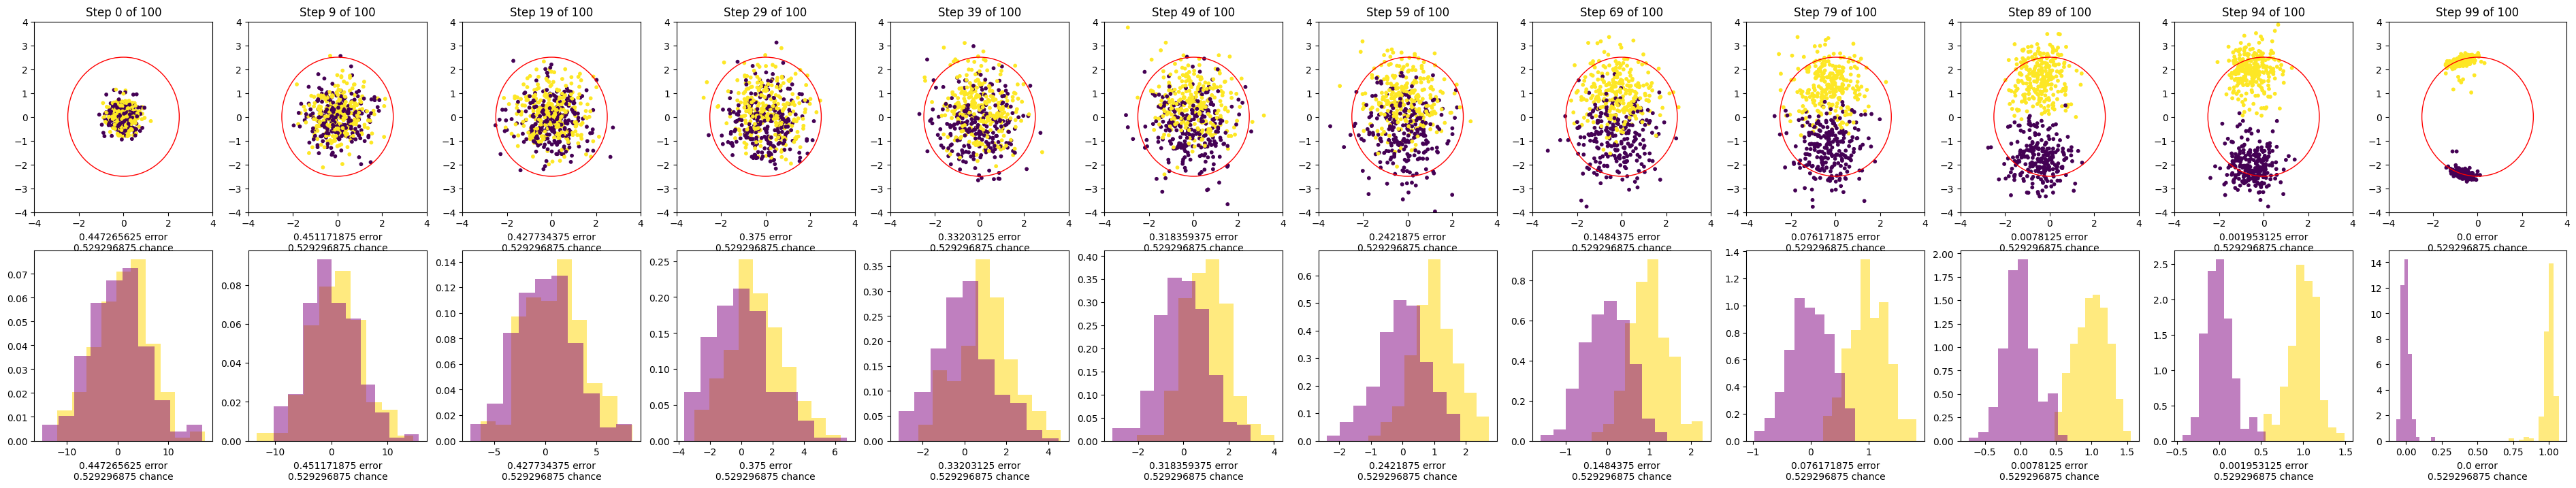

In [21]:
from sklearn.naive_bayes import GaussianNB

logging_ts = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 94, 99]

fig, axes = plt.subplots(2, len(logging_ts), figsize = (4*len(logging_ts),4*2), squeeze=False)

sample_space_traj = novel_samples_dict['sample_trajectory'][batch_idx]

for ax_idx, lts in enumerate(logging_ts):
    axes[0,ax_idx].scatter(*sample_space_traj[:,lts,:].T, c = mode_1_mask.int(), s = 10)

    gnb = GaussianNB().fit(sample_space_traj[:,lts,:], mode_1_mask.int())
    y_pred = gnb.predict(sample_space_traj[:,lts,:])
    error_rate = (y_pred != mode_1_mask.int().numpy()).mean()

    mean_conn_line = gnb.theta_[1] - gnb.theta_[0]      # Overkill to fit the whole GNB to this but might as well use it!
    offset_line = sample_space_traj[:,lts,:].cpu().numpy() - gnb.theta_[0][None]
    dist_along = np.sum(offset_line * mean_conn_line[None], -1)
    frac_along = dist_along / np.sum(mean_conn_line * mean_conn_line, -1)
    
    axes[0,ax_idx].add_patch(plt.Circle((0, 0), 2.5, color='red', fill = False))
    axes[0,ax_idx].set_xlim(-4,4); axes[0,ax_idx].set_ylim(-4,4)
    axes[0,ax_idx].set_title(f"Step {lts} of {ddpm_model.T}")
    axes[0,ax_idx].set_xlabel(f"{error_rate} error\n{mode_1_mask.float().mean()} chance")

    axes[1,ax_idx].hist(frac_along[mode_1_mask], color = 'gold', alpha = 0.5, density = True)
    axes[1,ax_idx].hist(frac_along[~mode_1_mask], color = 'purple', alpha = 0.5, density = True)
    axes[1,ax_idx].set_xlabel(f"{error_rate} error\n{mode_1_mask.float().mean()} chance")

Trajectory during denoising in nullspace, coloured by final mode

100%|██████████| 12/12 [00:00<00:00, 62.40it/s]


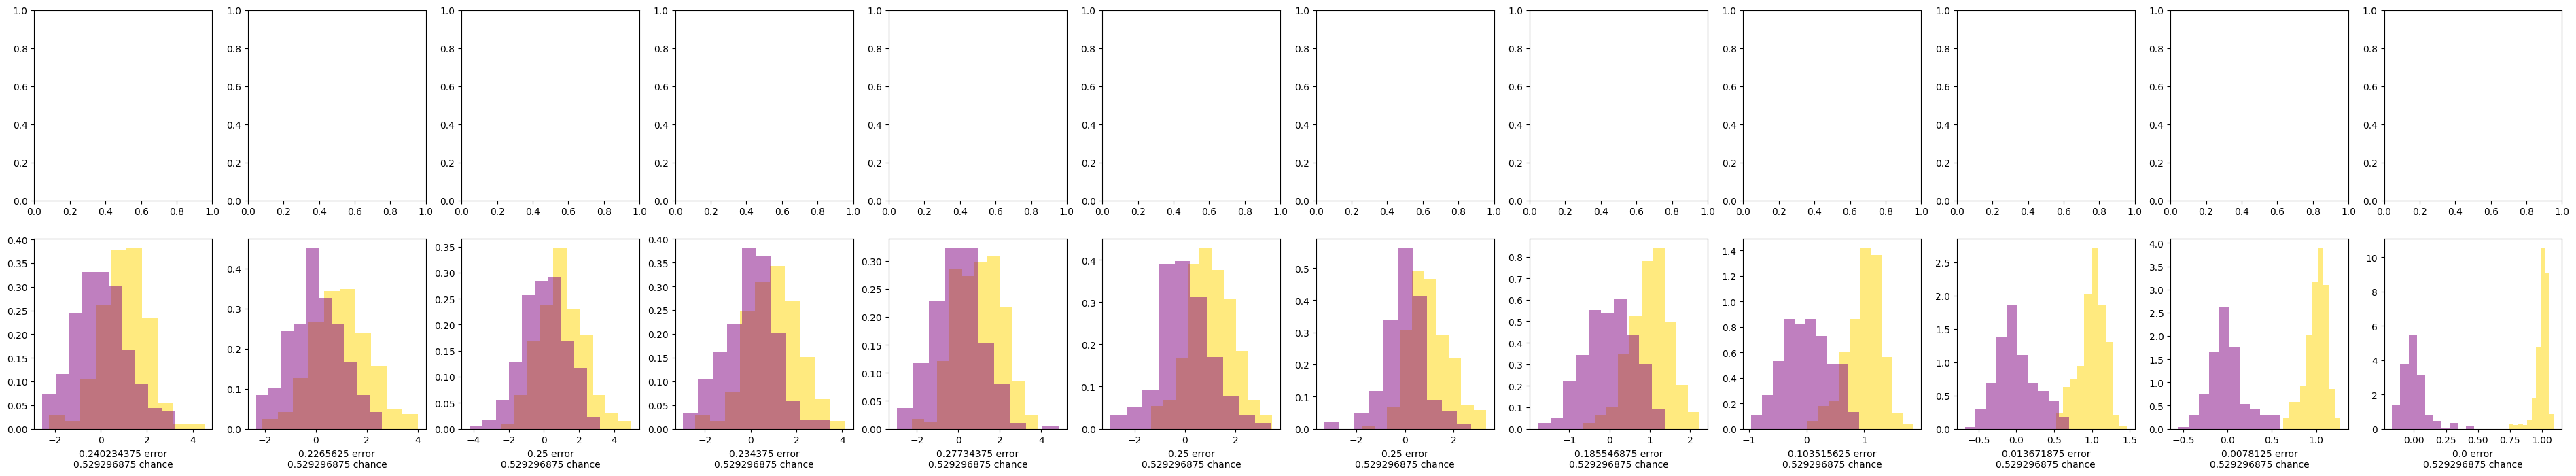

In [18]:
from tqdm import tqdm
import numpy as np


null_space_traj = novel_samples_dict['embedded_sample_trajectory'][batch_idx] @ ddpm_model.behaviour_nullspace.cpu().T

fig, axes = plt.subplots(2, len(logging_ts), figsize = (4*len(logging_ts), 4 * 2), squeeze=False)

for ax_idx, lts in tqdm(enumerate(logging_ts), total = len(logging_ts)):

    # timeslice_dim_red = DimRedMethod(n_components = ddpm_model.behaviour_nullspace.shape[0], **dim_red_kwargs).fit_transform()
    nullspace_activity_at_time = null_space_traj[:,lts,:]

    gnb = GaussianNB().fit(nullspace_activity_at_time, mode_1_mask.int())
    y_pred = gnb.predict(nullspace_activity_at_time)
    error_rate = (y_pred != mode_1_mask.int().numpy()).mean()

    # axes[0,ax_idx].scatter(nullspace_activity_at_time[:,44], nullspace_activity_at_time[:,21], c = mode_1_mask.int(), s = 10)

    mean_conn_line = gnb.theta_[1] - gnb.theta_[0]      # Overkill to fit the whole GNB to this but might as well use it!
    offset_line = nullspace_activity_at_time.cpu().numpy() - gnb.theta_[0][None]
    dist_along = np.sum(offset_line * mean_conn_line[None], -1)
    frac_along = dist_along / np.sum(mean_conn_line * mean_conn_line, -1)

    axes[1,ax_idx].hist(frac_along[mode_1_mask], color = 'gold', alpha = 0.5, density = True)
    axes[1,ax_idx].hist(frac_along[~mode_1_mask], color = 'purple', alpha = 0.5, density = True)
    axes[1,ax_idx].set_xlabel(f"{error_rate} error\n{mode_1_mask.float().mean()} chance")

100%|██████████| 5/5 [00:00<00:00, 60.97it/s]


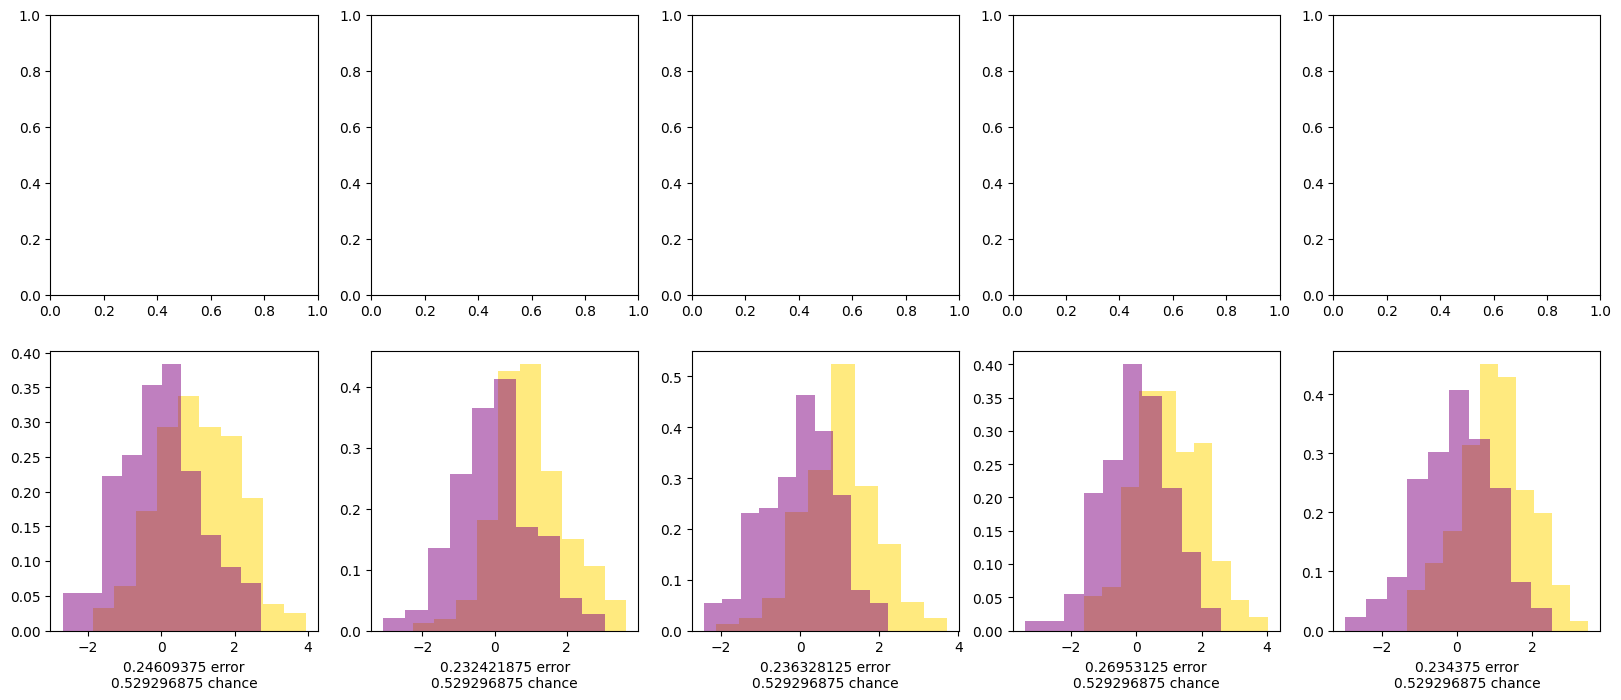

In [19]:
prep_logging_ts = [0, 4, 9, 14, 18]

prep_traj = novel_samples_dict['preparatory_trajectory'][batch_idx].detach().cpu()

fig, axes = plt.subplots(2, len(prep_logging_ts), figsize = (4*len(prep_logging_ts), 4 * 2), squeeze=False)

for ax_idx, lts in tqdm(enumerate(prep_logging_ts), total = len(prep_logging_ts)):

    # timeslice_dim_red = DimRedMethod(n_components = ddpm_model.behaviour_nullspace.shape[0], **dim_red_kwargs).fit_transform()
    prep_activity_at_time = prep_traj[:,lts,:]

    gnb = GaussianNB().fit(prep_activity_at_time, mode_1_mask.int())
    y_pred = gnb.predict(prep_activity_at_time)
    error_rate = (y_pred != mode_1_mask.int().numpy()).mean()

    # axes[0,ax_idx].scatter(prep_activity_at_time[:,44], prep_activity_at_time[:,21], c = mode_1_mask.int(), s = 10)

    mean_conn_line = gnb.theta_[1] - gnb.theta_[0]      # Overkill to fit the whole GNB to this but might as well use it!
    offset_line = prep_activity_at_time.cpu().numpy() - gnb.theta_[0][None]
    dist_along = np.sum(offset_line * mean_conn_line[None], -1)
    frac_along = dist_along / np.sum(mean_conn_line * mean_conn_line, -1)

    axes[1,ax_idx].hist(frac_along[mode_1_mask], color = 'gold', alpha = 0.5, density = True)
    axes[1,ax_idx].hist(frac_along[~mode_1_mask], color = 'purple', alpha = 0.5, density = True)
    axes[1,ax_idx].set_xlabel(f"{error_rate} error\n{mode_1_mask.float().mean()} chance")